# Importing Libraries

In [1]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread
import pathlib
import random

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Waring Library
import warnings
warnings.filterwarnings('ignore')

## Read Data and store it in dataframe

In [2]:
data_dir = '/kaggle/input/flowers-dataset/flower_photos'
filepaths = []
labels = []

folders = os.listdir(data_dir)
for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
df

filepaths     labels
0     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
1     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
2     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
3     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
4     /kaggle/input/flowers-dataset/flower_photos/da...  dandelion
...                                                 ...        ...
3665  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3666  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3667  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3668  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips
3669  /kaggle/input/flowers-dataset/flower_photos/tu...     tulips

[3670 rows x 2 columns]

In [4]:
# Visualize the number of classes count
df['labels'].value_counts()

labels
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64

In [5]:
df['labels'].shape

(3670,)

## Visualize Flower Species

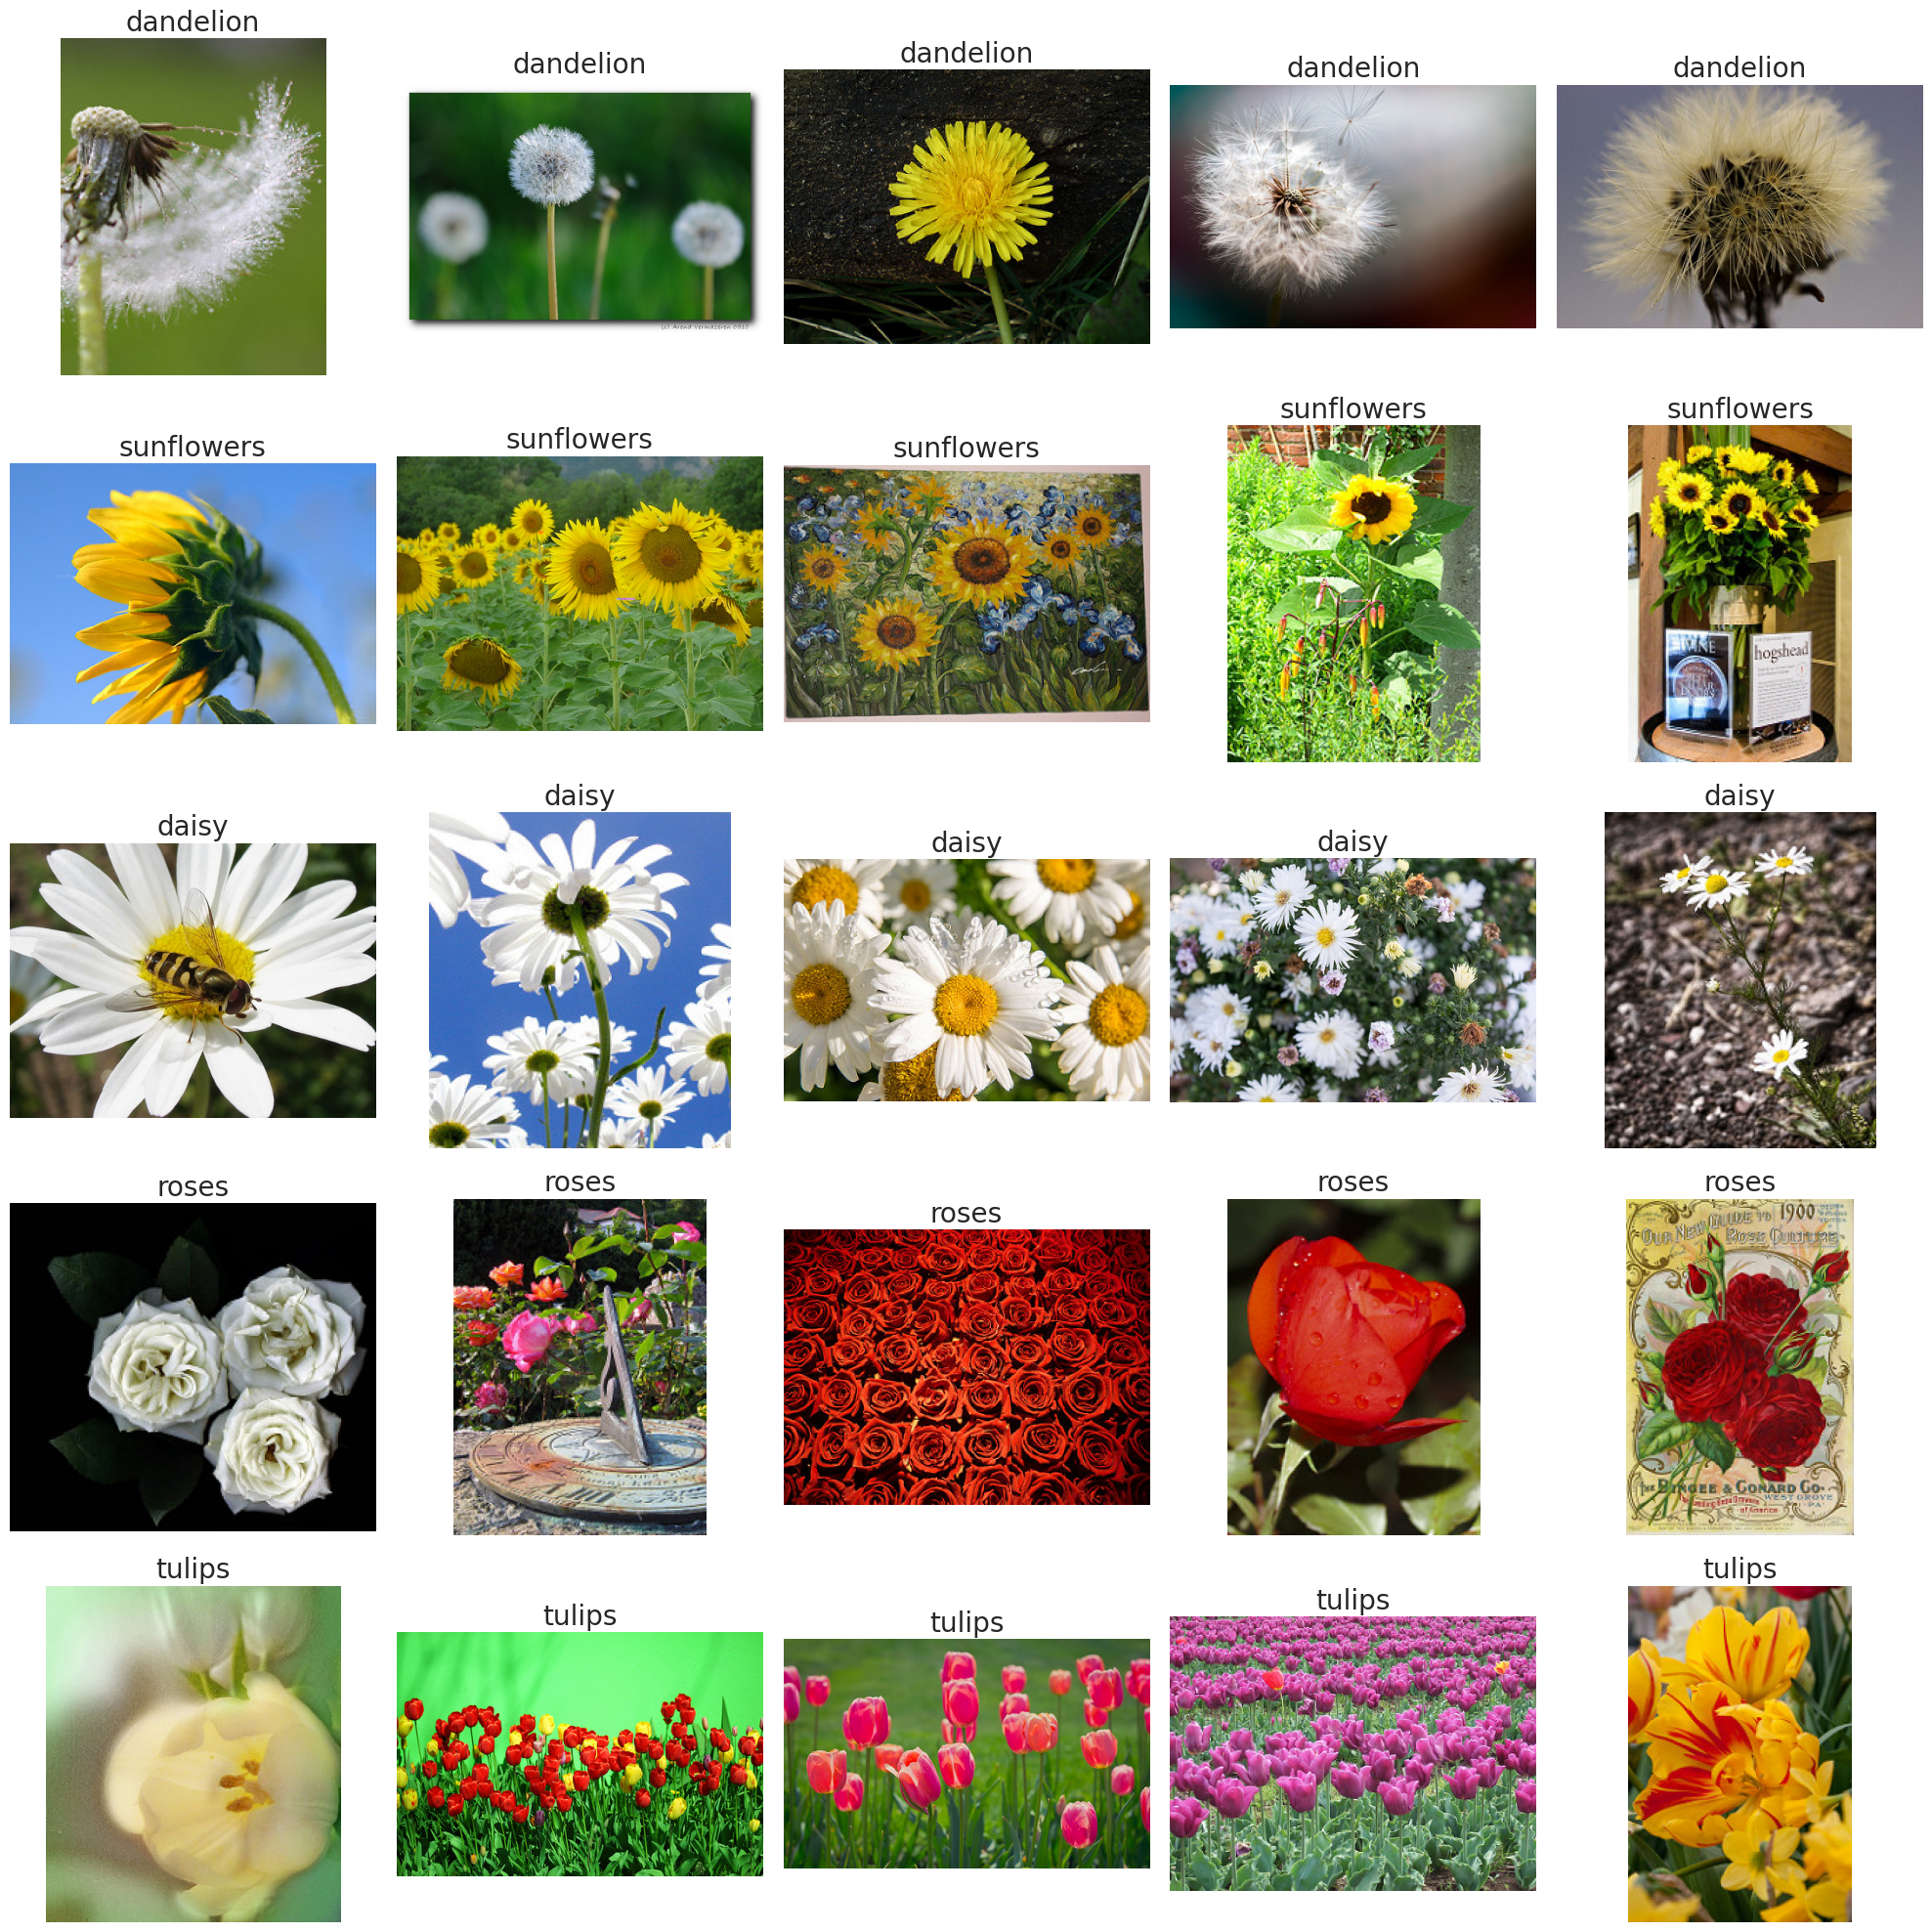

In [6]:
# Set the number of images to display per species
num_images = 5

# Get unique flower species labels
flower_species = df['labels'].unique()

# Set up the plot
plt.figure(figsize=(20, 20))

# Loop through each flower species
for idx, flower in enumerate(flower_species):
    # Filter the DataFrame to get file paths for this flower species
    flower_df = df[df['labels'] == flower].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(flower_df['filepaths'].values):
        plt.subplot(len(flower_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(flower)
        
# Show the plot
plt.tight_layout()
plt.show()

## Spliting the data into Training and Testing

In [11]:
# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.2, random_state=123, stratify=strat, shuffle=True)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.25, random_state=123, stratify=strat, shuffle=True)

In [12]:
train_df

filepaths      labels
609   /kaggle/input/flowers-dataset/flower_photos/da...   dandelion
2951  /kaggle/input/flowers-dataset/flower_photos/tu...      tulips
1036  /kaggle/input/flowers-dataset/flower_photos/su...  sunflowers
2503  /kaggle/input/flowers-dataset/flower_photos/ro...       roses
1849  /kaggle/input/flowers-dataset/flower_photos/da...       daisy
...                                                 ...         ...
1717  /kaggle/input/flowers-dataset/flower_photos/da...       daisy
2660  /kaggle/input/flowers-dataset/flower_photos/ro...       roses
1617  /kaggle/input/flowers-dataset/flower_photos/da...       daisy
2895  /kaggle/input/flowers-dataset/flower_photos/tu...      tulips
1198  /kaggle/input/flowers-dataset/flower_photos/su...  sunflowers

[2936 rows x 2 columns]

In [13]:
test_df

filepaths      labels
917   /kaggle/input/flowers-dataset/flower_photos/su...  sunflowers
3455  /kaggle/input/flowers-dataset/flower_photos/tu...      tulips
835   /kaggle/input/flowers-dataset/flower_photos/da...   dandelion
2643  /kaggle/input/flowers-dataset/flower_photos/ro...       roses
2864  /kaggle/input/flowers-dataset/flower_photos/ro...       roses
...                                                 ...         ...
1636  /kaggle/input/flowers-dataset/flower_photos/da...       daisy
3     /kaggle/input/flowers-dataset/flower_photos/da...   dandelion
1805  /kaggle/input/flowers-dataset/flower_photos/da...       daisy
82    /kaggle/input/flowers-dataset/flower_photos/da...   dandelion
575   /kaggle/input/flowers-dataset/flower_photos/da...   dandelion

[184 rows x 2 columns]

In [14]:
print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

Number of Training dataset: 2936
Number of Validation dataset: 550
Number of Testing dataset: 184


# Check if there are any corrupted images


In [15]:
import os
import cv2

corrupted_images = []
for filepath in df['filepaths']:
    try:
        img = cv2.imread(filepath)
        if img is None:
            corrupted_images.append(filepath)
    except Exception as e:
        corrupted_images.append(filepath)

# Print number of corrupted images
print(f"Number of corrupted images: {len(corrupted_images)}")

# Show a few corrupted image file paths
corrupted_images[:5]


Number of corrupted images: 0


[]

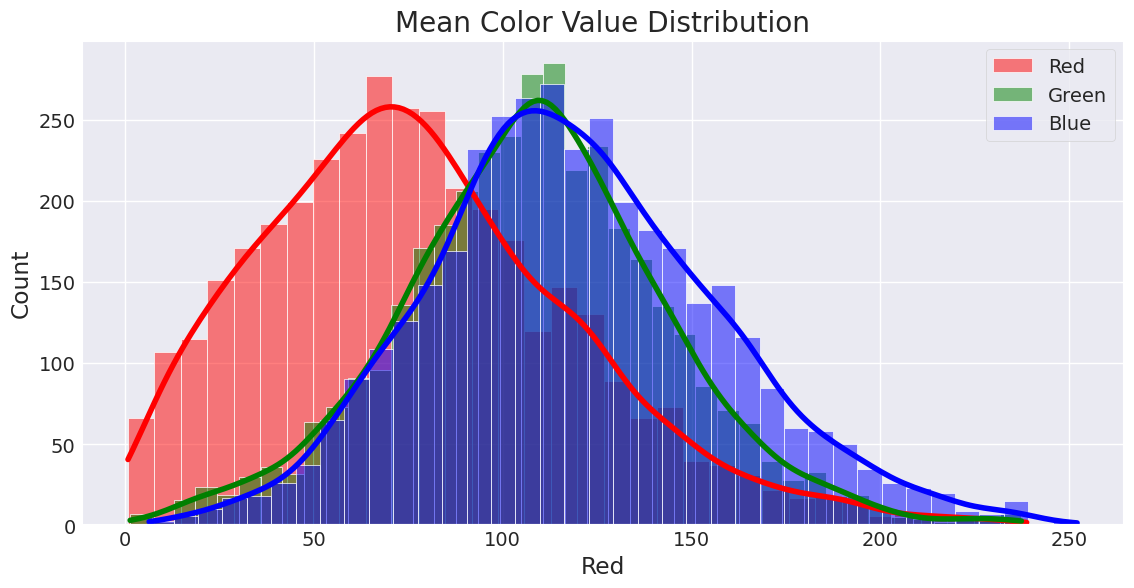

In [16]:
# Check the mean color value distribution across all images
color_means = {'Red': [], 'Green': [], 'Blue': []}

for filepath in df['filepaths']:
    img = cv2.imread(filepath)
    if img is not None:
        # Calculate the mean color value for each channel
        red, green, blue = cv2.split(img)
        color_means['Red'].append(red.mean())
        color_means['Green'].append(green.mean())
        color_means['Blue'].append(blue.mean())

# Create a dataframe for color means
color_means_df = pd.DataFrame(color_means)

# Plot the mean color values
plt.figure(figsize=(12, 6))
sns.histplot(color_means_df['Red'], color='red', label='Red', kde=True)
sns.histplot(color_means_df['Green'], color='green', label='Green', kde=True)
sns.histplot(color_means_df['Blue'], color='blue', label='Blue', kde=True)
plt.title('Mean Color Value Distribution')
plt.legend()
plt.show()


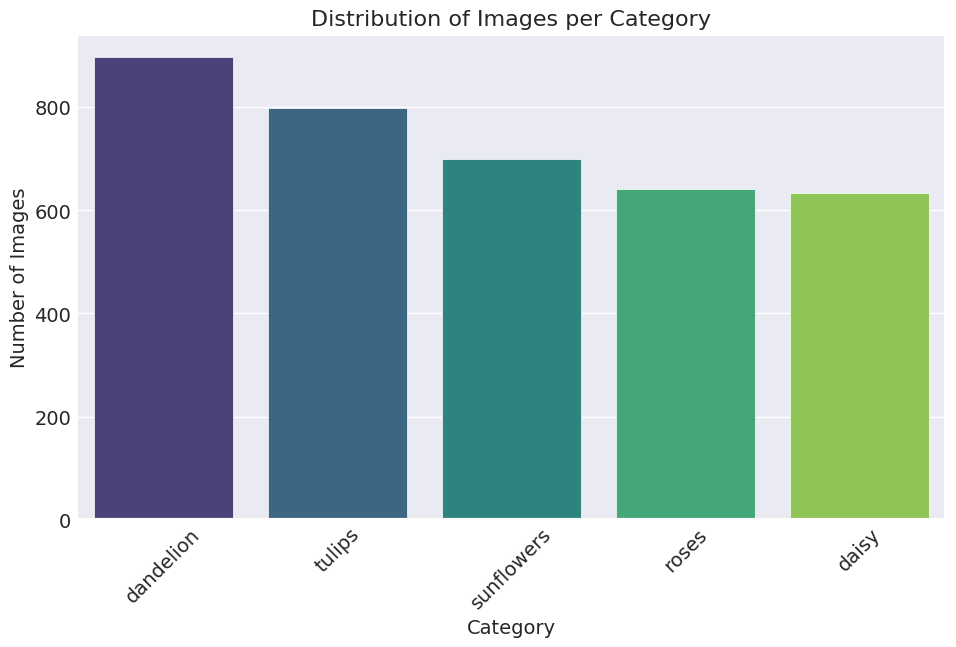

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of images in each category
category_counts = df['labels'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Images per Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45)
plt.show()


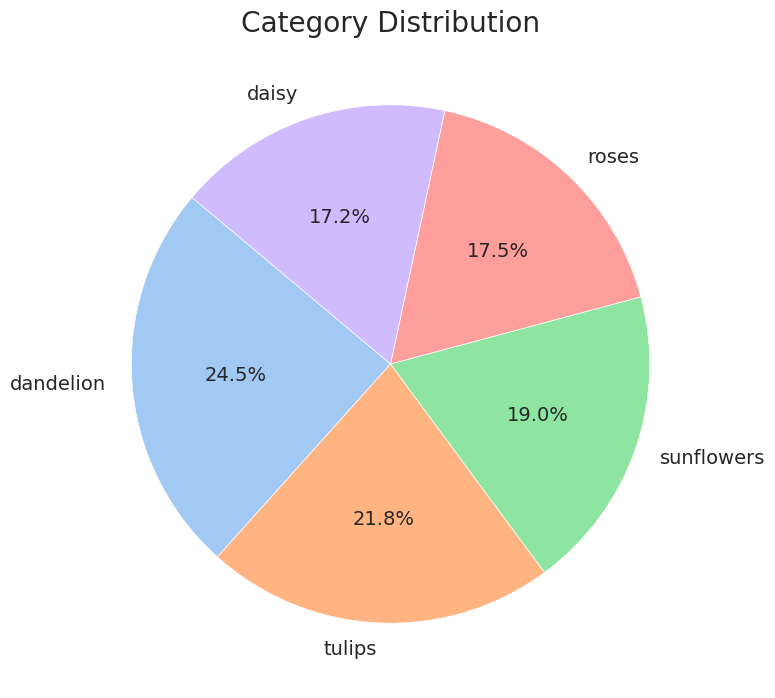

In [19]:
plt.figure(figsize=(8, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Category Distribution')
plt.show()


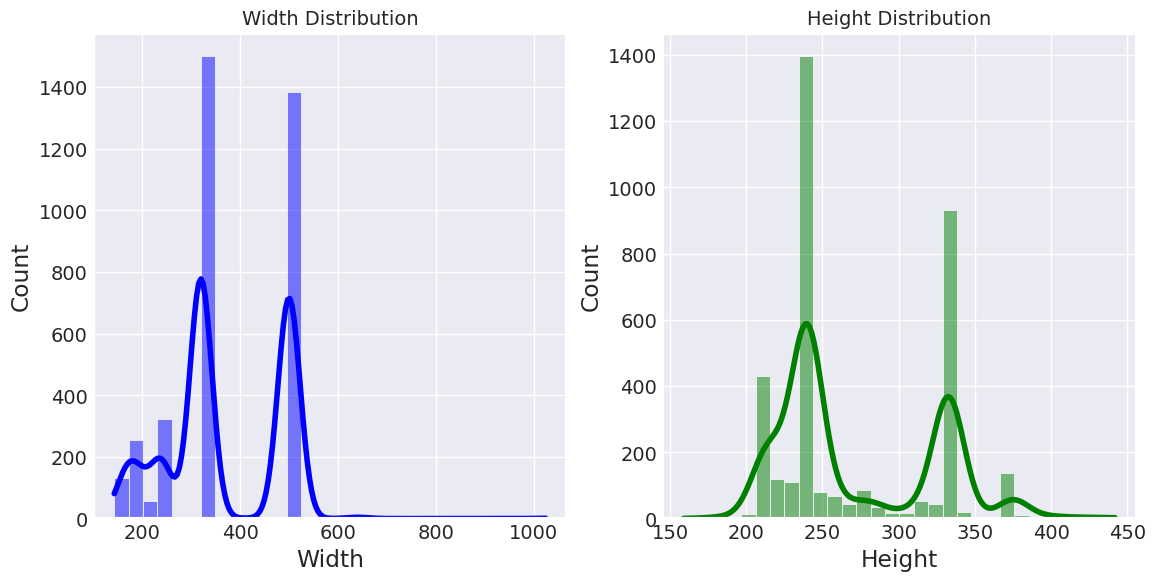

In [18]:
image_shapes = []
for filepath in df['filepaths']:
    img = cv2.imread(filepath)
    if img is not None:
        h, w, _ = img.shape
        image_shapes.append((w, h))

# Create a dataframe for image shapes
shape_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])

# Plot the distribution of widths and heights
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(shape_df['Width'], bins=30, color='blue', kde=True)
plt.title('Width Distribution', fontsize=14)

plt.subplot(1, 2, 2)
sns.histplot(shape_df['Height'], bins=30, color='green', kde=True)
plt.title('Height Distribution', fontsize=14)
plt.show()


## Create image data generator

In [20]:
# Parameters
batch_size = 32
img_size = (224, 224)  # Image size (cropped size)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Data augmentation for the training data
tr_gen = ImageDataGenerator(
    rotation_range=20,           # Rotate images up to 20 degrees
    width_shift_range=0.2,       # Shift images horizontally (20% of width)
    height_shift_range=0.2,      # Shift images vertically (20% of height)
    shear_range=0.2,             # Shearing transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill mode for pixels outside boundaries
)

# No augmentation for validation/test data, just rescaling
ts_gen = ImageDataGenerator()

# Generate training, validation, and test batches
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 2936 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 184 validated image filenames belonging to 5 classes.


In [40]:
label_dict = {v: k for k, v in train_gen.class_indices.items()}
label_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

# Visualize batches from each generator

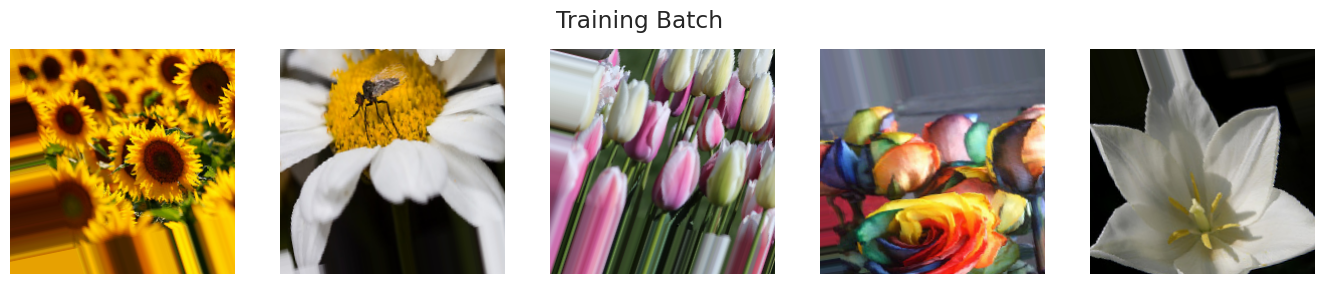

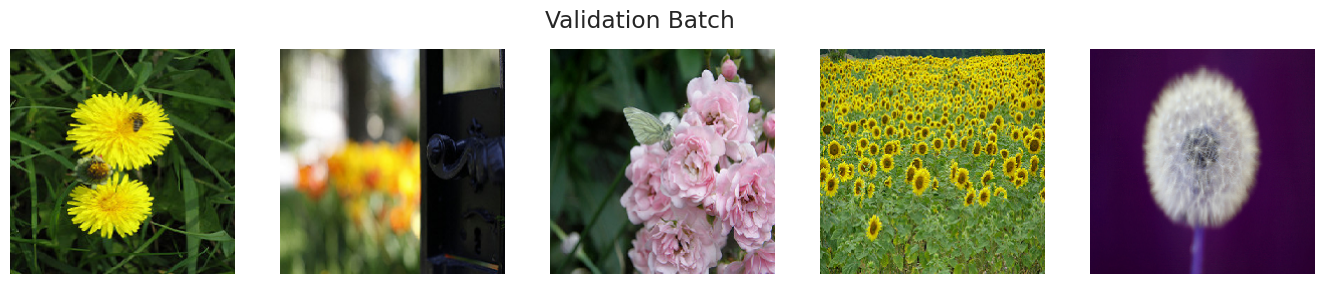

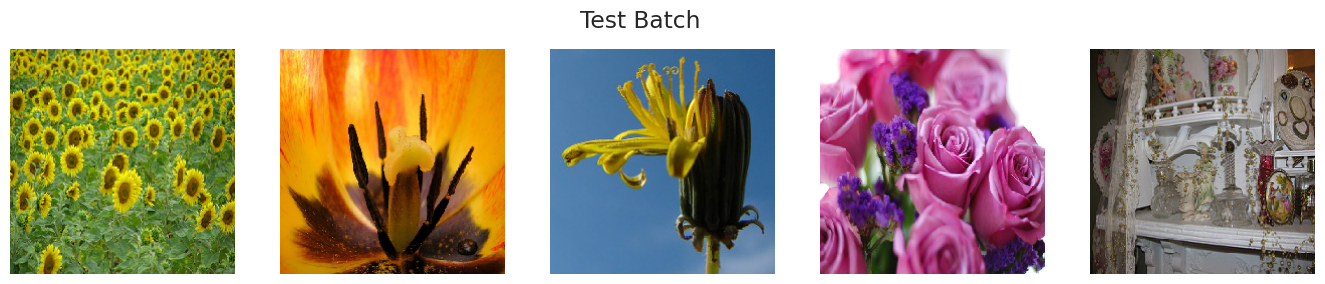

In [22]:

# Function to display a batch of images
def visualize_batch(batch_generator, title):
    # Get a batch of images and labels
    images, labels = next(batch_generator)

    # Set up the plot to display the images
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Display 5 images
    fig.suptitle(title)
    
    # Loop through the images and plot them
    for i in range(5):
        axes[i].imshow(images[i].astype('uint8'))  # Convert float to uint8 for proper display
        axes[i].axis('off')
    
    plt.show()

# Visualize batches from each generator
visualize_batch(train_gen, 'Training Batch')
visualize_batch(valid_gen, 'Validation Batch')
visualize_batch(test_gen, 'Test Batch')


# CNN

In [33]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import layers


base_model = EfficientNetB3(include_top= False, weights='imagenet',
                           input_shape=(224, 224, 3), pooling='max')

model = tf.keras.models.Sequential([
    base_model,
    layers.BatchNormalization(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.45, seed=123),
    layers.Dense(5, activation='softmax')
])


model.compile(optimizer = Adam(learning_rate = 0.001),loss = 'categorical_crossentropy', metrics = ['acc', tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,436 (42.67 MB)

 Trainable params: 11,094,061 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [35]:
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    # mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,               
    patience=3,               
    min_lr=1e-7               
)

In [36]:
history = model.fit(train_gen, epochs = 50, validation_data = valid_gen, callbacks = [early_stopping, reduce_lr])

Epoch 1/50


I0000 00:00:1735638994.733901     116 service.cc:145] XLA service 0x79bd18004210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735638994.733960     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1735639083.098657     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - acc: 0.6681 - auc: 0.8908 - loss: 1.0495 - precision: 0.7181 - recall: 0.6322 - val_acc: 0.8727 - val_auc: 0.9713 - val_loss: 0.5945 - val_precision: 0.8791 - val_recall: 0.8727 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 375ms/step - acc: 0.8755 - auc: 0.9812 - loss: 0.3774 - precision: 0.9014 - recall: 0.8564 - val_acc: 0.9000 - val_auc: 0.9819 - val_loss: 0.3660 - val_precision: 0.9170 - val_recall: 0.8836 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - acc: 0.8963 - auc: 0.9864 - loss: 0.3075 - precision: 0.9205 - recall: 0.8751 - val_acc: 0.8782 - val_auc: 0.9805 - val_loss: 0.3702 - val_precision: 0.8895 - val_recall: 0.8636 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - acc: 0.9134 - auc: 0.9907 - loss: 0.2586 - precision: 0.9256 - recall: 0.9043 - val_acc: 0.9164 - val_auc: 0.9901 - val_loss: 0.2642 - val_precision: 0.9286 - val_recall: 0.8982 - learnin

In [37]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 396ms/step - acc: 0.9889 - auc: 0.9996 - loss: 0.0404 - precision: 0.9902 - recall: 0.9882
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - acc: 0.9258 - auc: 0.9878 - loss: 0.2473 - precision: 0.9293 - recall: 0.9187
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - acc: 0.9257 - auc: 0.9956 - loss: 0.1895 - precision: 0.9479 - recall: 0.9217
Train Loss:  0.04075317829847336
Train Accuracy:  0.9877384305000305
--------------------
Valid Loss:  0.17319639027118683
Valid Accuracy:  0.9381818175315857
--------------------
Test Loss:  0.1972597986459732
Test Accuracy:  0.929347813129425


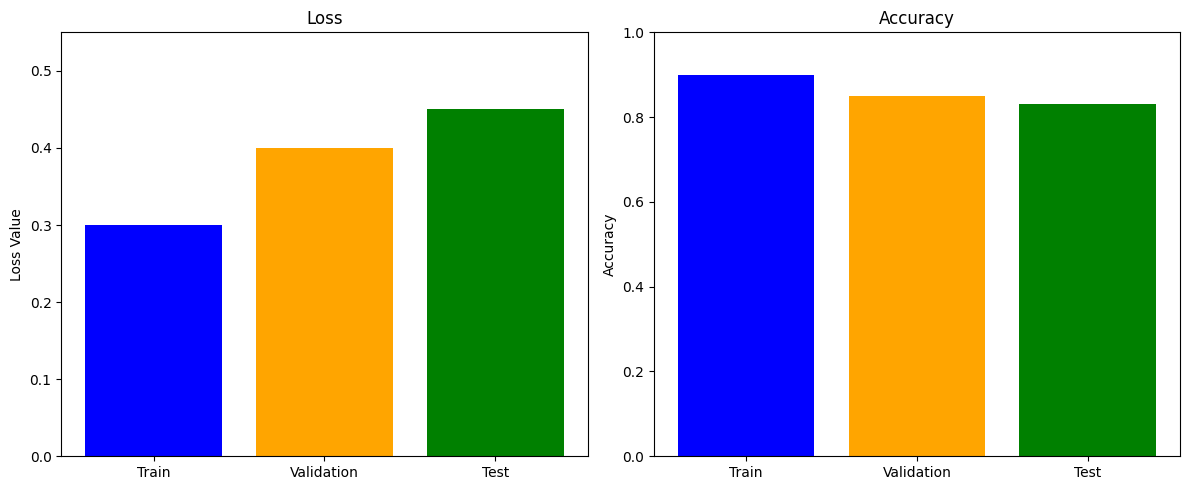

In [42]:

# Extracting Loss and Accuracy for each set
losses = [train_score[0], valid_score[0], test_score[0]]
accuracies = [train_score[1], valid_score[1], test_score[1]]
categories = ['Train', 'Validation', 'Test']

# Plotting Loss and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
ax[0].bar(categories, losses, color=['blue', 'orange', 'green'])
ax[0].set_title('Loss')
ax[0].set_ylabel('Loss Value')
ax[0].set_ylim(0, max(losses) + 0.1)

# Accuracy plot
ax[1].bar(categories, accuracies, color=['blue', 'orange', 'green'])
ax[1].set_title('Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0, 1)

# Display plots
plt.tight_layout()
plt.show()


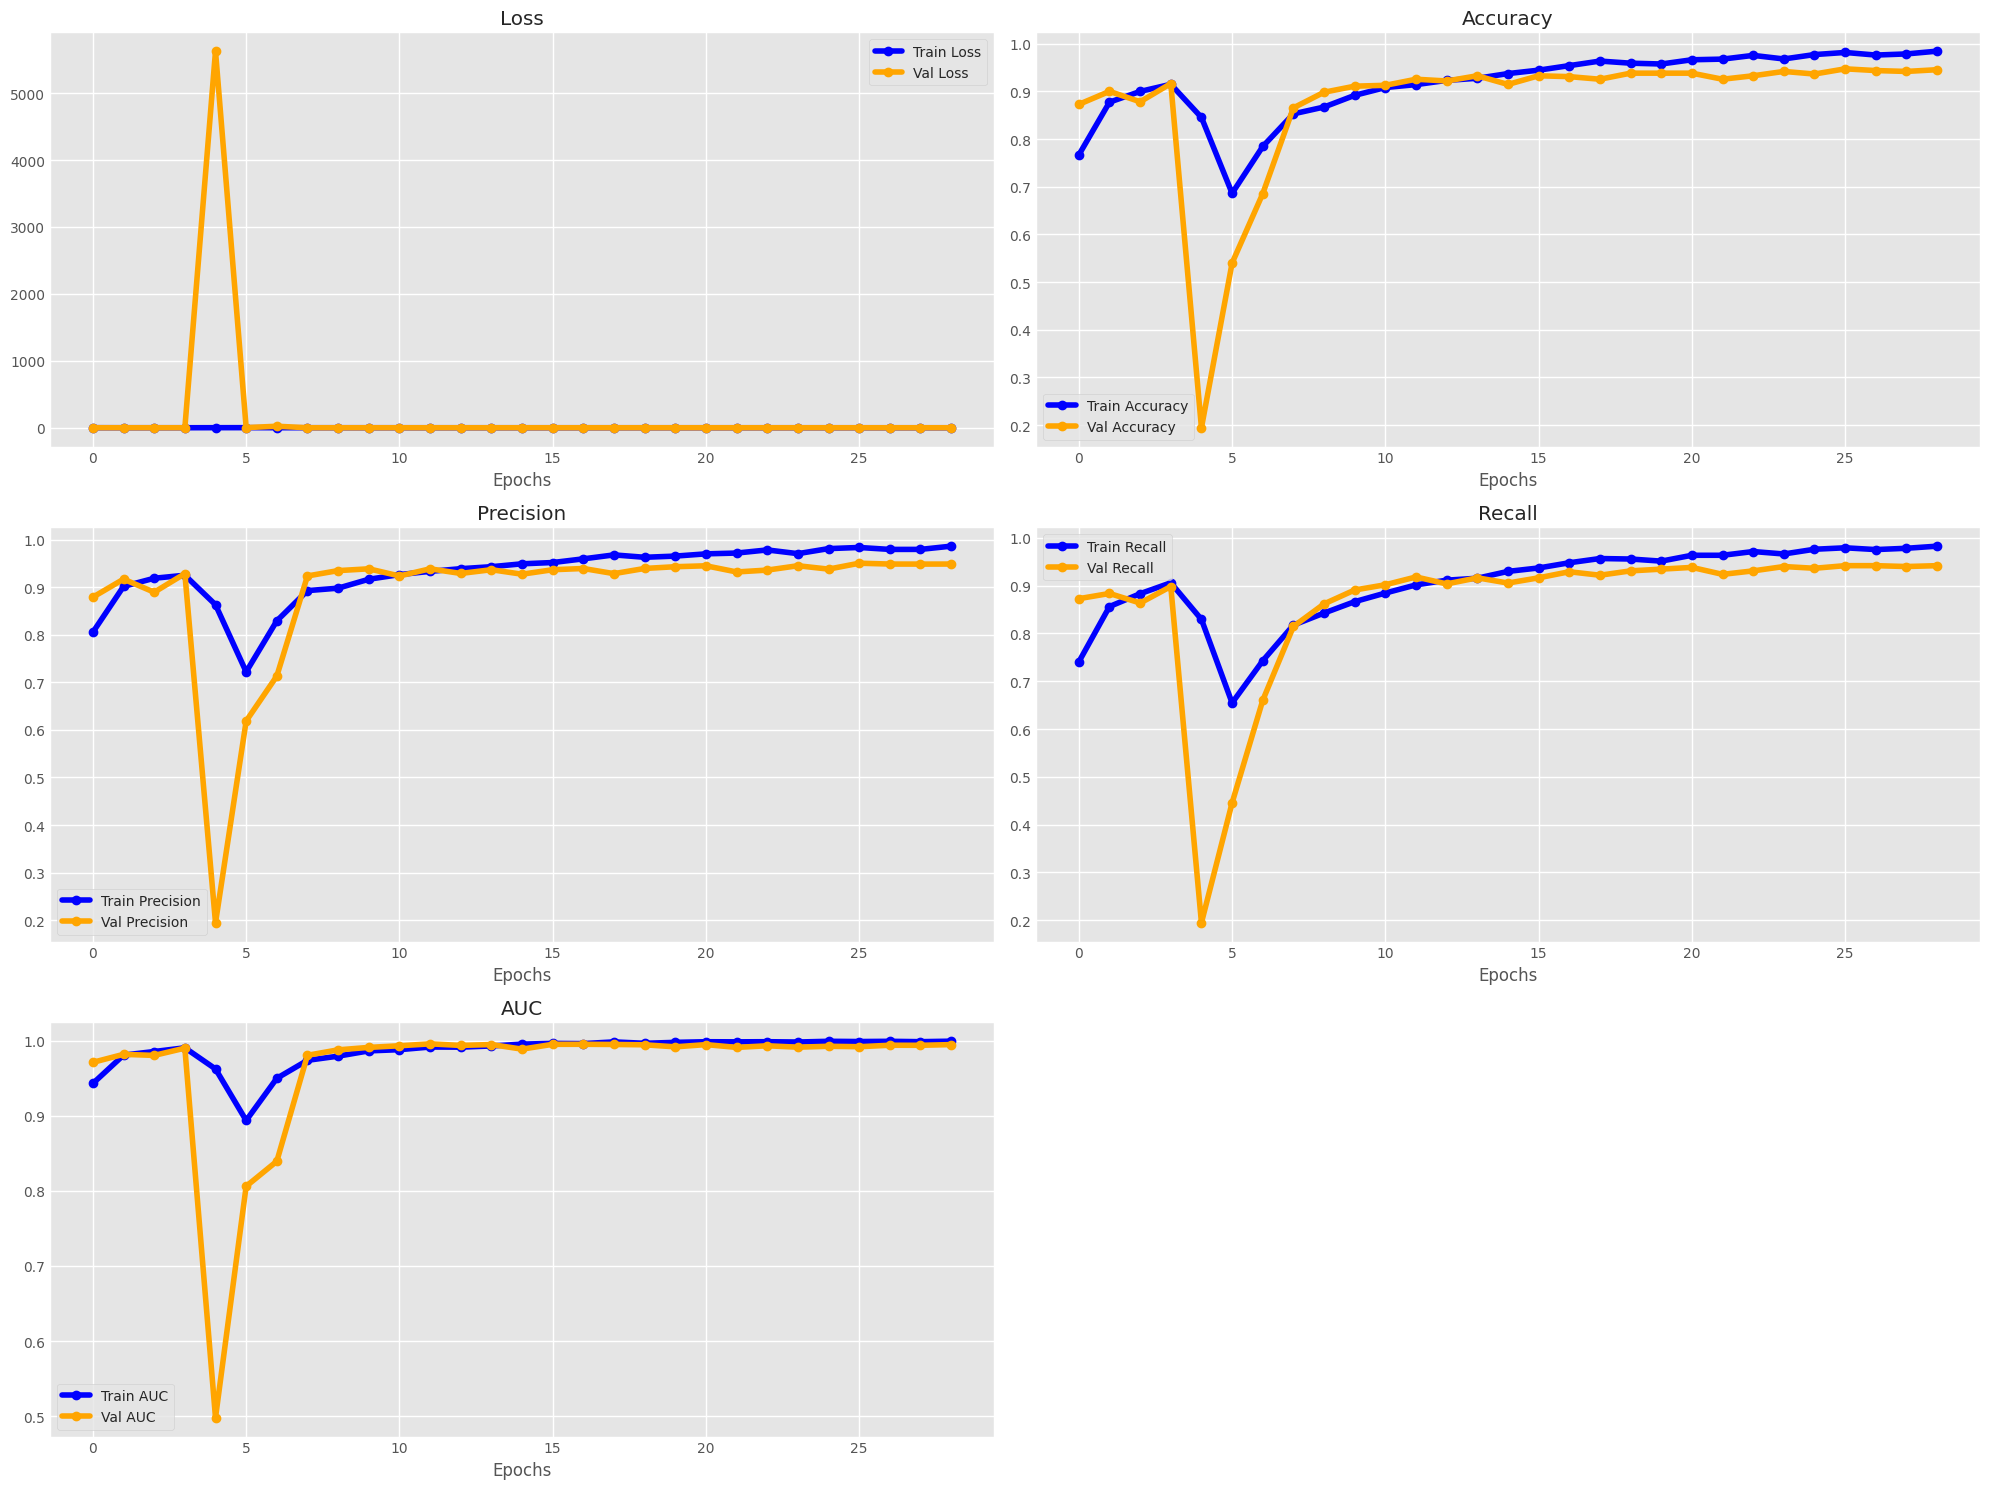

In [38]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["acc"]
    val_accuracy = history.history["val_acc"]
    
    precision = history.history["precision"]
    val_precision = history.history["val_precision"]
    
    recall = history.history["recall"]
    val_recall = history.history["val_recall"]
    
    auc = history.history["auc"]
    val_auc = history.history["val_auc"]
    
    epochs = range(len(loss))
    
    plt.figure(figsize=(20, 15))
    plt.style.use('ggplot')
    
    # Plot Loss
    plt.subplot(3, 2, 1)
    plt.plot(epochs, loss, 'bo-', label="Train Loss")
    plt.plot(epochs, val_loss, 'o-', color='orange', label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label="Train Accuracy")
    plt.plot(epochs, val_accuracy, 'o-', color='orange', label="Val Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot Precision
    plt.subplot(3, 2, 3)
    plt.plot(epochs, precision, 'bo-', label="Train Precision")
    plt.plot(epochs, val_precision, 'o-', color='orange', label="Val Precision")
    plt.title("Precision")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot Recall
    plt.subplot(3, 2, 4)
    plt.plot(epochs, recall, 'bo-', label="Train Recall")
    plt.plot(epochs, val_recall, 'o-', color='orange', label="Val Recall")
    plt.title("Recall")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot AUC
    plt.subplot(3, 2, 5)
    plt.plot(epochs, auc, 'bo-', label="Train AUC")
    plt.plot(epochs, val_auc, 'o-', color='orange', label="Val AUC")
    plt.title("AUC")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.style.use('default')
    plt.show()

plot_curves(history)

# Save Model

In [39]:
#Save the model
model.save('model.h5')